# Data Preprocessing

## Table of Contents
  - [1. Download data](#1.-download-data)
  - [2. Extract data](#2.-extract-data)
  - [3. Transform data](#3.-transform-data)
  - [3. Load data](#3.-load-data)
  - [4. Visualize some plot](#4.-visualize-some-plot)



## 1. Download data

**EEG data for Mental Attention State Detection**

URL: https://www.kaggle.com/datasets/inancigdem/eeg-data-for-mental-attention-state-detection/data

In [108]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("inancigdem/eeg-data-for-mental-attention-state-detection")

print("Path to dataset files:", path)

Path to dataset files: /home/thangquang/.cache/kagglehub/datasets/inancigdem/eeg-data-for-mental-attention-state-detection/versions/1


In [109]:
# Import Librabies
import os 
from scipy.io import loadmat
from scipy.signal import butter, lfilter
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

In [110]:
# path = "/home/thangquang/.cache/kagglehub/datasets/inancigdem/eeg-data-for-mental-attention-state-detection/versions/1"
files = os.listdir(path)
print(f"Folder: {files}")
for file in files:
    new_path = os.path.join(path, file)
    print(f"Folder {file} has {len(os.listdir(new_path))} files")

Folder: ['eeg data', 'EEG Data']
Folder eeg data has 1 files
Folder EEG Data has 34 files


In [111]:
# Join file paths and sort
data_path = os.path.join(path, 'EEG Data')
data_files = [os.path.join(data_path, file) for file in os.listdir(data_path)]
data_files.sort(key=lambda x: int(x.split('eeg_record')[1].split('.mat')[0]))
# Verify sorted paths
for file in data_files[:3]:
    print(file) 

/home/thangquang/.cache/kagglehub/datasets/inancigdem/eeg-data-for-mental-attention-state-detection/versions/1/EEG Data/eeg_record1.mat
/home/thangquang/.cache/kagglehub/datasets/inancigdem/eeg-data-for-mental-attention-state-detection/versions/1/EEG Data/eeg_record2.mat
/home/thangquang/.cache/kagglehub/datasets/inancigdem/eeg-data-for-mental-attention-state-detection/versions/1/EEG Data/eeg_record3.mat


## 2. Extract data

In [112]:
# load first .mat file
mat_data = loadmat(data_files[0])

print(mat_data.keys())

dict_keys(['__header__', '__version__', '__globals__', 'o'])


According to the dataset's context, the raw data is stored in 'o', and each column in the 'o' data represents a data channel.

In [113]:
o_data = mat_data['o']
o_data

array([[(array(['201410092013.D091BB44'], dtype='<U21'), array([], dtype='<U1'), array([[308868]], dtype=int32), array([[128]], dtype=uint8), array([[0],
               [0],
               [0],
               ...,
               [0],
               [0],
               [0]], dtype=uint8), array([[2.0140e+03, 1.0000e+01, 9.0000e+00, 2.0000e+01, 1.4000e+01,
                1.5360e+00],
               [2.0140e+03, 1.0000e+01, 9.0000e+00, 2.0000e+01, 1.4000e+01,
                1.5360e+00],
               [2.0140e+03, 1.0000e+01, 9.0000e+00, 2.0000e+01, 1.4000e+01,
                1.5360e+00],
               ...,
               [2.0140e+03, 1.0000e+01, 9.0000e+00, 2.0000e+01, 5.4000e+01,
                1.6494e+01],
               [2.0140e+03, 1.0000e+01, 9.0000e+00, 2.0000e+01, 5.4000e+01,
                1.6494e+01],
               [2.0140e+03, 1.0000e+01, 9.0000e+00, 2.0000e+01, 5.4000e+01,
                1.6494e+01]]), array([[  3.,   0., 463., ...,   0.,   0.,   0.],
               [ 

The raw data is contained in `o.data`, which is an array of size {number-of-samples}x25. Thus, `o.data(:,i)` comprises one data channel, which we will focus on.

In [114]:
columns = ['ED_COUNTER', 'ED_INTERPOLATED', 'ED_RAW_CQ', 'ED_AF3', 'ED_F7', 'ED_F3', 'ED_FC5', 'ED_T7', 'ED_P7', 'ED_O1',
           'ED_O2', 'ED_P8', 'ED_T8', 'ED_FC6', 'ED_F4', 'ED_F8', 'ED_AF4', 'ED_GYROX', 'ED_GYROY', 'ED_TIMESTAMP',
           'ED_ES_TIMESTAMP', 'ED_FUNC_ID', 'ED_FUNC_VALUE', 'ED_MARKER', 'ED_SYNC_SIGNAL']

data = o_data[0][0]['data']
df = pd.DataFrame(data, columns=columns)
df = df.reset_index()
df = df.rename(columns = {'index': 't'})
print('Number of rows:', len(df))
df.head()

Number of rows: 308868


,t,ED_COUNTER,ED_INTERPOLATED,ED_RAW_CQ,ED_AF3,ED_F7,ED_F3,ED_FC5,ED_T7,ED_P7,...,ED_F8,ED_AF4,ED_GYROX,ED_GYROY,ED_TIMESTAMP,ED_ES_TIMESTAMP,ED_FUNC_ID,ED_FUNC_VALUE,ED_MARKER,ED_SYNC_SIGNAL
0,0,3.0,0.0,463.0,4440.000000,4417.948718,5390.769231,3833.846154,4019.487179,4656.410256,...,4335.384615,4563.589744,1573.0,1726.0,764.304,0.031277,0.0,0.0,0.0,0.0
1,1,4.0,0.0,0.0,4439.487179,4417.948718,5389.230769,3830.256410,4020.000000,4658.974359,...,4331.794872,4566.666667,1570.0,1727.0,764.304,0.031277,0.0,0.0,0.0,0.0
2,2,5.0,0.0,447.0,4438.974359,4414.871795,5385.641026,3829.743590,4017.948718,4655.897436,...,4333.846154,4557.948718,1567.0,1726.0,764.304,0.031277,0.0,0.0,0.0,0.0
3,3,6.0,0.0,500.0,4438.974359,4410.256410,5381.025641,3831.794872,4016.410256,4649.230769,...,4334.358974,4552.820513,1564.0,1723.0,764.304,0.031277,0.0,0.0,0.0,0.0
4,4,7.0,0.0,424.0,4439.487179,4407.179487,5378.461538,3831.282051,4019.487179,4647.692308,...,4334.358974,4546.666667,1565.0,1720.0,764.304,0.031277,0.0,0.0,0.0,0.0


| ID  | Channel Name        | Meaning                                                   |
|-----|---------------------|-----------------------------------------------------------|
| 1   | `'ED_COUNTER'`       | Counter for collected data samples.                       |
| 2   | `'ED_INTERPOLATED'`   | Data interpolation state.                                 |
| 3   | `'ED_RAW_CQ'`         | Raw data quality from sensors.                            |
| 4–17| EEG Channels        | Channels containing EEG data (electroencephalography).    |
| 18  | `'ED_GYROX'`          | Data from gyroscope sensor (X-axis).                      |
| 19  | `'ED_GYROY'`          | Data from gyroscope sensor (Y-axis).                      |
| 20  | `'ED_TIMESTAMP'`      | Timestamp.                                                |
| 21  | `'ED_ES_TIMESTAMP'`   | Event timestamp.                                          |
| 22  | `'ED_FUNC_ID'`        | Function ID code.                                         |
| 23  | `'ED_FUNC_VALUE'`     | Function value.                                           |
| 24  | `'ED_MARKER'`         | Event marker.                                             |
| 25  | `'ED_SYNC_SIGNAL'`    | Synchronization signal.                                   |


## 3. Transform data

### 3.1. Create target column

Since the sampling frequency is 128 Hz (128 data points are taken each second), the column `t` represents the sampling times (starting from 0).

According to the dataset's author, during the first 10 minutes of each experiment, the participant is in a `focused` state, the next 10 minutes are in an `unfocused` state, and after that, the participant is in a `drowsy` state.

Therefore, if we convert to sampling times, the formula for the first sample at minute $i$ is $i \times 128 \times 60$, where $128$ is the sampling frequency.

In [115]:
def get_state(t):
    if t <= 10 * 128 * 60:
        return 'focused'
    elif t > 20 * 128 * 60:
        return 'drownsy'
    else:
        return 'unfocused'

Extract data from columns 4 to 17, representing 14 channels, and then create a `state` column.

In [116]:
chanel_columns = ['t']  # get i's sample
chanel_columns.extend(df.columns[4:18])  # 14 channels
df_chanels = df[chanel_columns].copy()
df_chanels['state'] = df_chanels['t'].apply(get_state)
df_chanels.head()

,t,ED_AF3,ED_F7,ED_F3,ED_FC5,ED_T7,ED_P7,ED_O1,ED_O2,ED_P8,ED_T8,ED_FC6,ED_F4,ED_F8,ED_AF4,state
0,0,4440.000000,4417.948718,5390.769231,3833.846154,4019.487179,4656.410256,4742.051282,4415.384615,4538.461538,4308.205128,4125.641026,4283.589744,4335.384615,4563.589744,focused
1,1,4439.487179,4417.948718,5389.230769,3830.256410,4020.000000,4658.974359,4738.974359,4414.871795,4535.897436,4308.205128,4136.410256,4284.615385,4331.794872,4566.666667,focused
2,2,4438.974359,4414.871795,5385.641026,3829.743590,4017.948718,4655.897436,4734.358974,4414.871795,4537.435897,4308.205128,4152.820513,4283.076923,4333.846154,4557.948718,focused
3,3,4438.974359,4410.256410,5381.025641,3831.794872,4016.410256,4649.230769,4730.256410,4409.743590,4535.384615,4308.717949,4157.948718,4283.076923,4334.358974,4552.820513,focused
4,4,4439.487179,4407.179487,5378.461538,3831.282051,4019.487179,4647.692308,4729.230769,4408.205128,4526.666667,4307.179487,4157.948718,4285.641026,4334.358974,4546.666667,focused


Finally, the function to extract data from a .mat file to a pd.DataFrame will be implemented like this:

In [117]:
def extract_data(file_path):
   mat_data = loadmat(file_path)
   data = mat_data['o'][0][0]['data']
   columns = ['ED_COUNTER', 'ED_INTERPOLATED', 'ED_RAW_CQ', 'ED_AF3', 'ED_F7', 'ED_F3', 'ED_FC5', 'ED_T7', 'ED_P7', 'ED_O1',
         'ED_O2', 'ED_P8', 'ED_T8', 'ED_FC6', 'ED_F4', 'ED_F8', 'ED_AF4', 'ED_GYROX', 'ED_GYROY', 'ED_TIMESTAMP',
         'ED_ES_TIMESTAMP', 'ED_FUNC_ID', 'ED_FUNC_VALUE', 'ED_MARKER', 'ED_SYNC_SIGNAL']

   lowcut = 0.4
   highcut = 40
   fs = 128

   df = pd.DataFrame(data, columns=columns)
   df = df.reset_index()
   df = df.rename(columns = {'index': 't'})
   chanel_columns = ['t'] 
   chanel_columns.extend(df.columns[4:18])
   df_chanels = df[chanel_columns].copy()
   df_chanels['state'] = df_chanels['t'].apply(get_state)

   return df_chanels

## 4. Load data

In [118]:
# extract all 34 experiments and save to CSV file
for i, file_path in enumerate(data_files):
    new_df = extract_data(file_path=file_path)
    new_df.to_csv(f'data/extracted_eeg{i}.csv', index=False)

In [119]:
# Verify data is loaded
test_df = pd.read_csv('data/extracted_eeg15.csv')
print(len(test_df))
test_df.tail()

234372


,t,ED_AF3,ED_F7,ED_F3,ED_FC5,ED_T7,ED_P7,ED_O1,ED_O2,ED_P8,ED_T8,ED_FC6,ED_F4,ED_F8,ED_AF4,state
234367,234367,4436.410256,3955.897436,5036.923077,3829.743590,4045.128205,4303.076923,4272.820513,4044.615385,4106.666667,4304.102564,4138.974359,4282.051282,4335.384615,4092.307692,drownsy
234368,234368,4436.410256,3964.102564,5045.641026,3830.769231,4045.128205,4308.717949,4275.897436,4051.794872,4112.307692,4304.102564,4140.000000,4282.051282,4334.871795,4097.435897,drownsy
234369,234369,4436.410256,3975.384615,5058.974359,3829.743590,4045.128205,4314.358974,4283.076923,4059.487179,4125.641026,4304.102564,4139.487179,4282.051282,4332.820513,4107.692308,drownsy
234370,234370,4436.410256,3974.358974,5057.435897,3829.743590,4045.128205,4310.769231,4281.025641,4057.948718,4125.128205,4304.102564,4138.461538,4282.051282,4333.333333,4108.717949,drownsy
234371,234371,4436.410256,3971.282051,5053.333333,3831.282051,4045.128205,4314.871795,4283.076923,4056.410256,4123.589744,4304.102564,4141.538462,4282.051282,4334.358974,4105.641026,drownsy


## 5. Visualize some plot

In [120]:
def plot_chanel_signal(df, chanel):
    focused_df = test_df[test_df['state'] == 'focused']
    unfocused_df = test_df[test_df['state'] == 'unfocused']
    drownsy_df = test_df[test_df['state'] == 'drownsy']

    plt.figure(figsize=(16, 6))
    plt.plot(focused_df['t'], focused_df[chanel])
    plt.plot(unfocused_df['t'], unfocused_df[chanel])
    plt.plot(drownsy_df['t'], drownsy_df[chanel])
    plt.title(f"{chanel} signal by time")
    plt.xlabel('Time')
    plt.ylabel(f'{chanel} Signal')
    plt.legend(['Focused', 'Unfocused', 'Drownsy'])
    plt.tight_layout()
    plt.show()

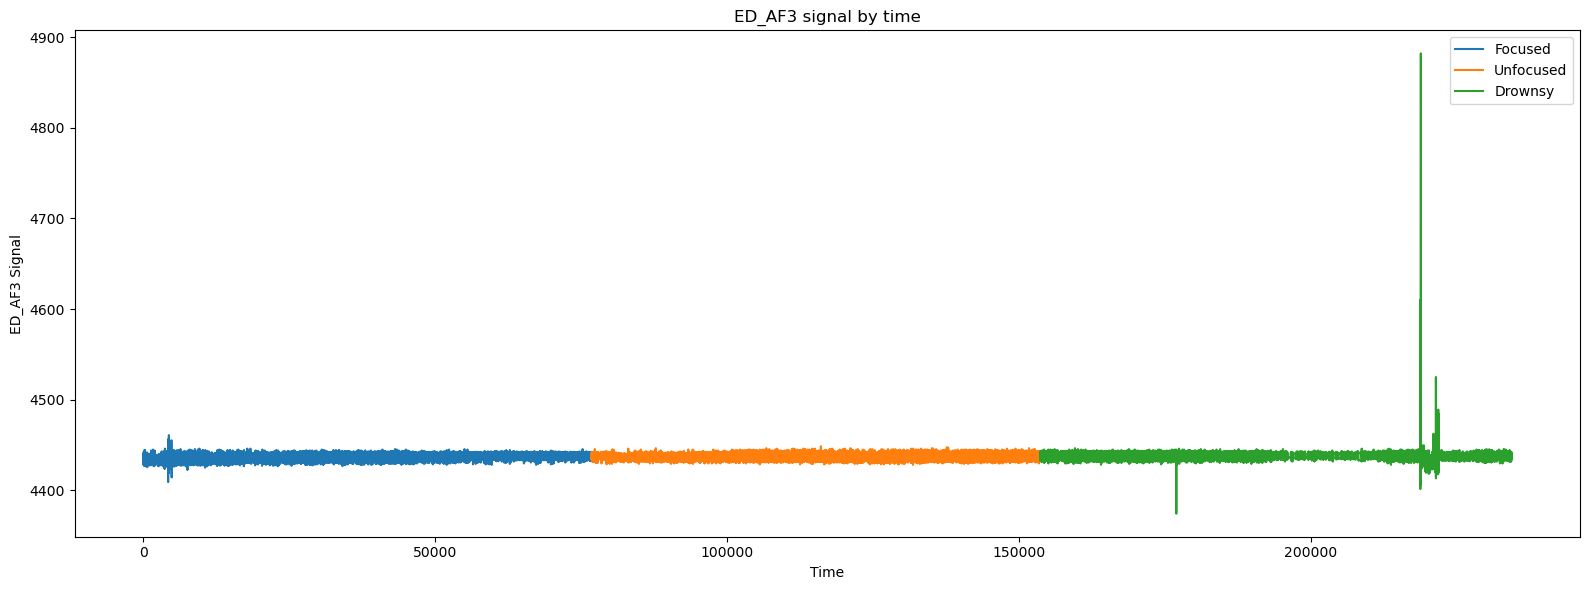

In [121]:
plot_chanel_signal(test_df, 'ED_AF3')

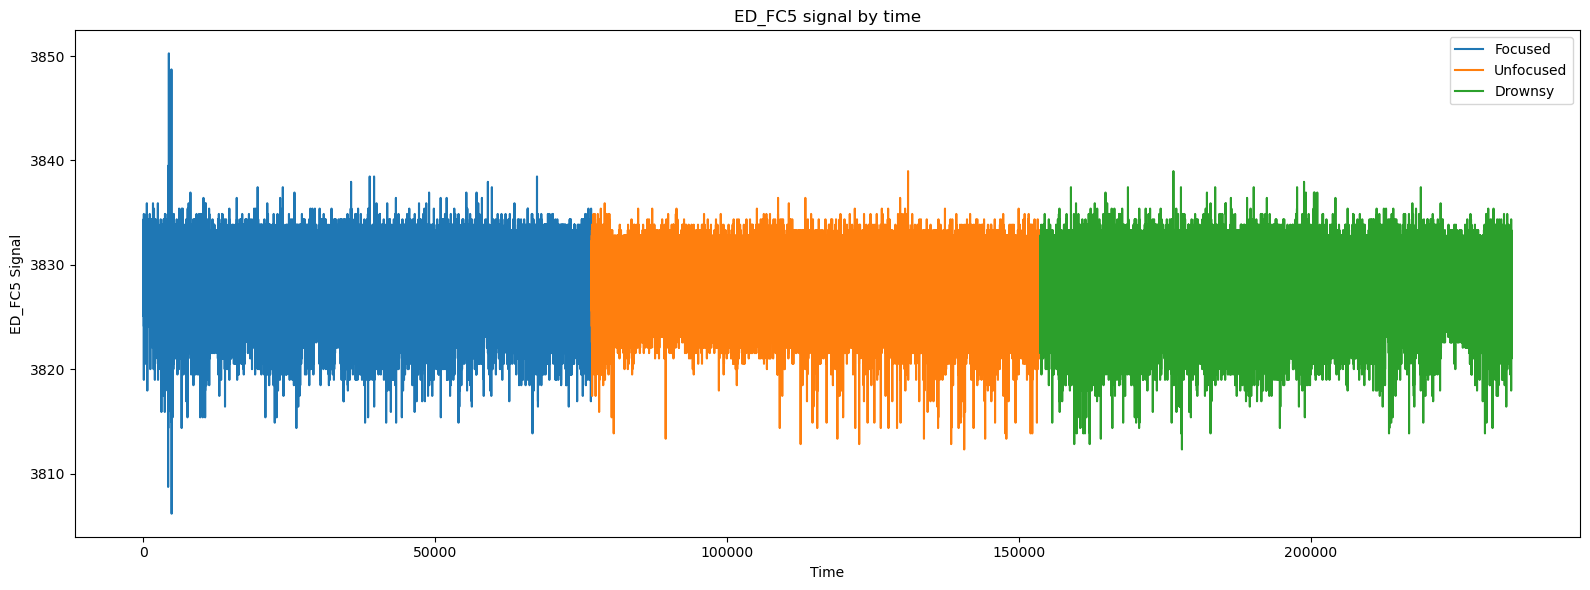

In [122]:
plot_chanel_signal(test_df, 'ED_FC5')

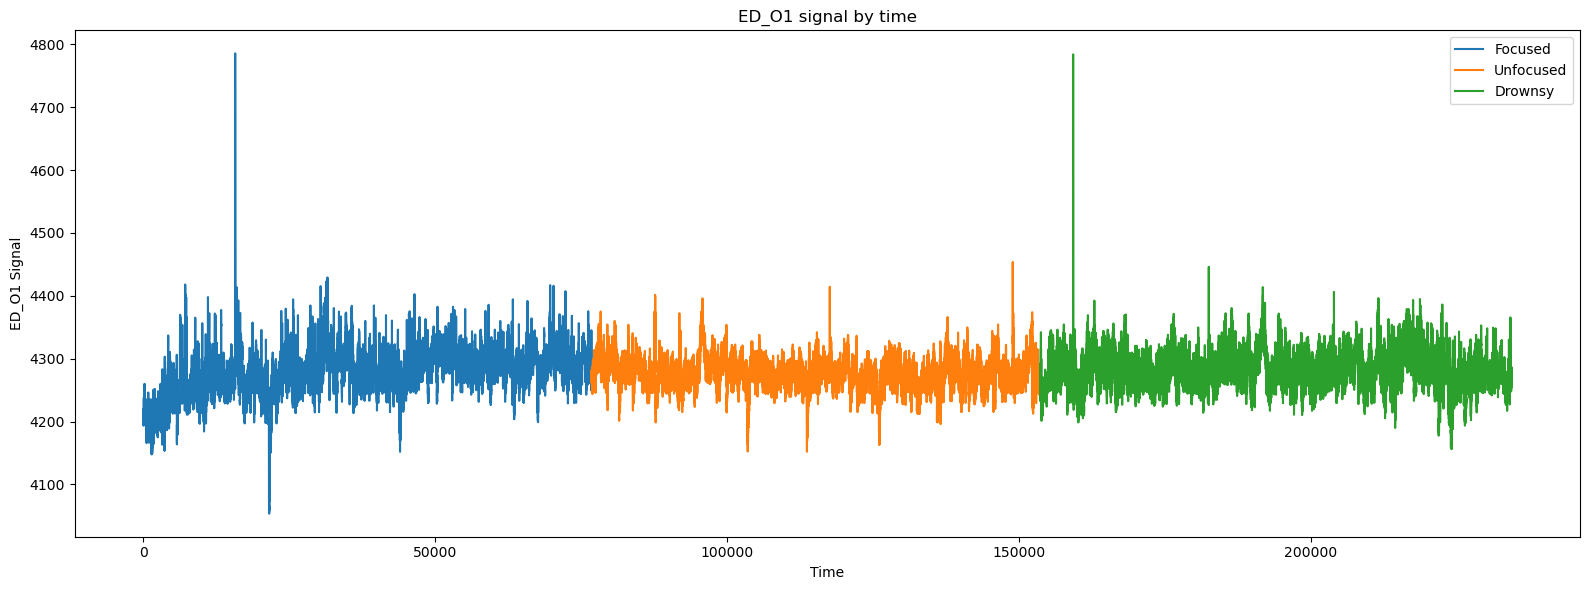

In [123]:
plot_chanel_signal(test_df, 'ED_O1')

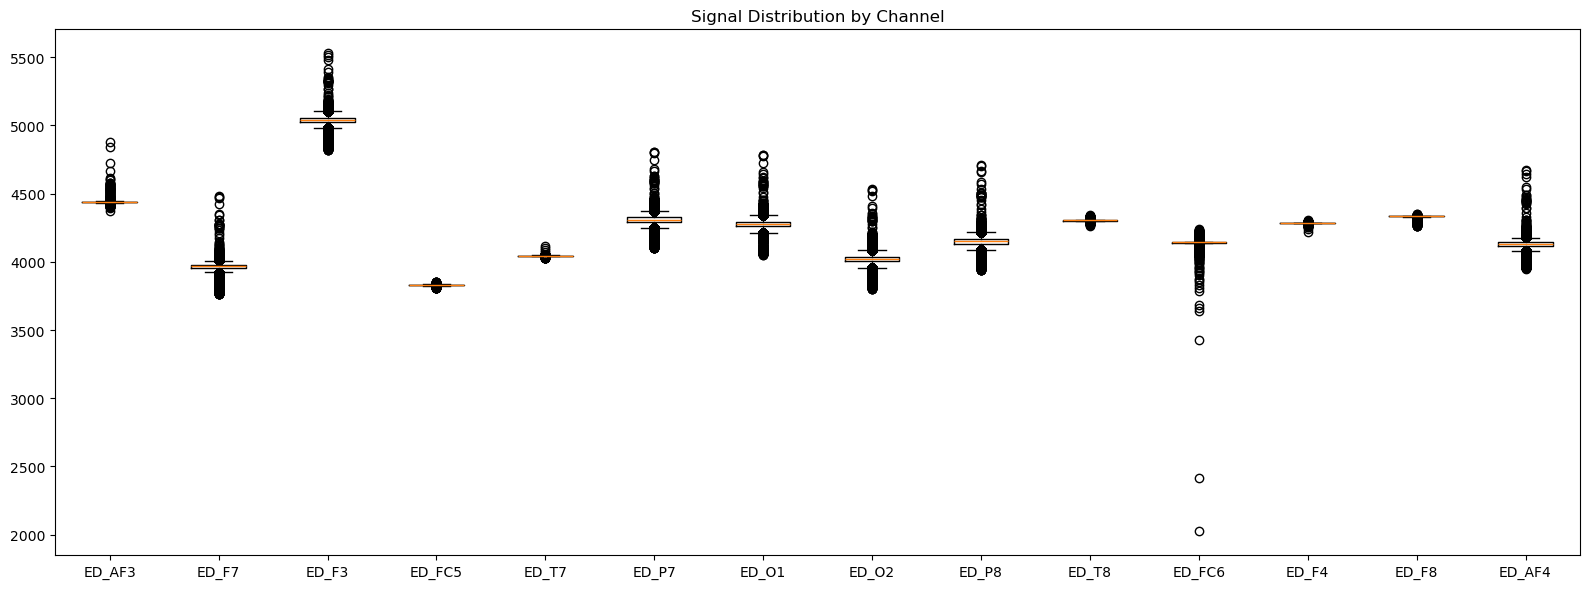

In [124]:
plt.figure(figsize=(16, 6))
plt.boxplot([test_df[column] for column in test_df.columns[1:-1]], tick_labels=test_df.columns[1:-1])
plt.title('Signal Distribution by Channel')
plt.tight_layout()
plt.show()